#**Multi class classification**

##**Dependences**

In [120]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd

## **Data loading**

In [121]:
X_blob,y_blob=make_blobs(n_samples=1500,n_features=2,random_state=42,centers=4,cluster_std=1.5)
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor).unsqueeze(dim=1)

In [122]:
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,random_state=42,stratify=y_blob,test_size=0.2)

In [123]:
y_blob_train.shape

torch.Size([1200, 1])

In [124]:
pd.Series(y_blob.squeeze().cpu().numpy()).unique()

array([2, 3, 1, 0])

## **Data Visualizing**

In [125]:
# plt.figure()
# plt.scatter(X_blob[:,0],X_blob[:,4],c=y_blob,cmap=plt.cm.RdYlBu)
# plt.legend(list(pd.Series(y_blob.squeeze().cpu().numpy()).unique()))

In [126]:
y_blob.dtype

torch.int64

In [127]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [128]:
model=nn.Sequential(
    nn.Linear(in_features=2,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=256),
    nn.Linear(in_features=256,out_features=4)
    ).to(device)

In [129]:
## Traning loop
epochs=1500
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)
x_train=X_blob_train.to(device)
y_train=y_blob_train.to(device)
x_test=X_blob_test.to(device)
y_test=y_blob_test.to(device)


In [130]:
y_train.dtype

torch.int64

In [131]:
def accuracy_fn(y_true,y_pred):
  assert len(y_true)==len(y_true),"exception"
  correct=0
  for i in range(len(y_pred)):
    if y_true[i]==y_pred[i]:
      correct+=1
  return correct/len(y_pred)*100


In [132]:
for epoch in range(epochs):
  model.train()
  y_logits=model(x_train)
  y_prob=torch.softmax(y_logits,dim=1)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  train_acc=accuracy_fn(y_train.squeeze().cpu().numpy(),y_pred.cpu().numpy())

  ##calculate the loss

  loss=loss_fn(y_logits,y_train.squeeze())

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## testing eval

  if epoch%100==0 or epoch==0 or epoch==1499:
    model.eval()
    with torch.inference_mode():
      test_logits=model(x_test)
      test_prob=torch.softmax(test_logits,dim=1)
      test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
      test_loss=loss_fn(test_logits,y_test.squeeze())
      test_acc=accuracy_fn(y_test.squeeze().cpu().numpy(),test_pred.cpu().numpy())
      print(f"epoch:{epoch} train loss:{loss},Train accuracy:{train_acc},test loss:{test_loss},Test_accuracy:{test_acc}")

epoch:0 train loss:1.94725501537323,Train accuracy:25.0,test loss:0.9755861163139343,Test_accuracy:73.33333333333333
epoch:100 train loss:0.050382982939481735,Train accuracy:98.83333333333333,test loss:0.05445408448576927,Test_accuracy:99.0
epoch:200 train loss:0.04011973366141319,Train accuracy:98.83333333333333,test loss:0.044388607144355774,Test_accuracy:99.0
epoch:300 train loss:0.03651179000735283,Train accuracy:98.83333333333333,test loss:0.040763162076473236,Test_accuracy:99.0
epoch:400 train loss:0.03467978164553642,Train accuracy:98.83333333333333,test loss:0.03889041766524315,Test_accuracy:99.0
epoch:500 train loss:0.033574178814888,Train accuracy:98.83333333333333,test loss:0.03774373233318329,Test_accuracy:99.0
epoch:600 train loss:0.03283315524458885,Train accuracy:98.83333333333333,test loss:0.03696371242403984,Test_accuracy:99.0
epoch:700 train loss:0.03229939565062523,Train accuracy:98.83333333333333,test loss:0.03639276698231697,Test_accuracy:99.0
epoch:800 train loss:

In [133]:
model(x_test).shape

torch.Size([300, 4])

In [134]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y."""
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


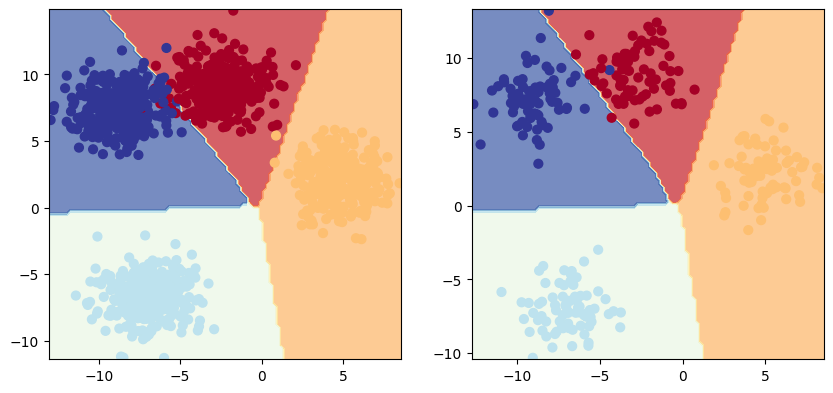

In [138]:
import numpy as np
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plot_decision_boundary(model,x_train,y_train)
plt.subplot(2,2,2)
plot_decision_boundary(model,x_test,y_test)